In [87]:
import numpy as np
import torch
import torchvision


trainingdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=True,download=True,transform=torchvision.transforms.ToTensor())
testdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=False,download=True,transform=torchvision.transforms.ToTensor())

In [88]:
trainDataLoader = torch.utils.data.DataLoader(trainingdata,batch_size=64,shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testdata,batch_size=64,shuffle=False)

In [89]:
import torch.nn as nn
import torch.nn.functional as F
class LinearReg(torch.nn.Module):
  def __init__(self):
    super(LinearReg, self).__init__()
    # number of hidden nodes in each layer (512)
    hidden_1 = 256
    hidden_2 = 128
    hidden_3 = 64
    # linear layer (784 -> hidden_1)
    self.fc1 = nn.Linear(28*28, 256)
    # linear layer (n_hidden -> hidden_2)
    self.fc2 = nn.Linear(256,128)
    # linear layer (n_hidden -> 10)
    self.fc3 = nn.Linear(128,64)
    # linear layer (n_hidden -> 10)
    self.fc4 = nn.Linear(64,10)
    # dropout layer (p=0.2)
    # dropout prevents overfitting of data
    self.droput = nn.Dropout(0.2)

  def forward(self, x):
    x = x.view(-1,28*28)
    # add hidden layer, with relu activation function
    x = F.relu(self.fc1(x))
    # add dropout layer
    x = self.droput(x)
    # add hidden layer, with relu activation function
    x = F.relu(self.fc2(x))
    # add dropout layer
    x = self.droput(x)
    # add hidden layer, with relu activation function
    x = F.relu(self.fc3(x))
    # add dropout layer
    x = self.droput(x)
    # add output layer
    x = self.fc4(x)
    return x
    

net = LinearReg().cuda()
Loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

In [90]:
train_loss_history = []
test_loss_history = []

for epoch in range(20):
  train_loss = 0.0
  test_loss = 0.0
  for i, data in enumerate(trainDataLoader):
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    optimizer.zero_grad()
    predicted_output = net(images)
    fit = Loss(predicted_output,labels)
    fit.backward()
    optimizer.step()
    train_loss += fit.item()
  for i, data in enumerate(testDataLoader):
    with torch.no_grad():
      images, labels = data
      images = images.cuda()
      labels = labels.cuda()
      predicted_output = net(images)
      fit = Loss(predicted_output,labels)
      test_loss += fit.item()
  train_loss = train_loss/len(trainDataLoader)
  test_loss = test_loss/len(testDataLoader)
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  print('Epoch %s, Train loss %s, Test loss %s'%(epoch, train_loss, test_loss))

Epoch 0, Train loss 2.108701184360203, Test loss 1.4668738492734872
Epoch 1, Train loss 1.111543722434847, Test loss 0.9504572384676356
Epoch 2, Train loss 0.8532997983605114, Test loss 0.8091288087474313
Epoch 3, Train loss 0.7408010307977448, Test loss 0.7219649213514511
Epoch 4, Train loss 0.672186011444531, Test loss 0.6713133439136918
Epoch 5, Train loss 0.6219932792791679, Test loss 0.6177574291730382
Epoch 6, Train loss 0.5798570286236338, Test loss 0.5890892499191746
Epoch 7, Train loss 0.5522617003810939, Test loss 0.5625270028972322
Epoch 8, Train loss 0.5243266202144022, Test loss 0.5447482662216113
Epoch 9, Train loss 0.5039620550869625, Test loss 0.5251780866058009
Epoch 10, Train loss 0.4850224937393721, Test loss 0.5158205653072163
Epoch 11, Train loss 0.4717302181954577, Test loss 0.4949921110443249
Epoch 12, Train loss 0.45728539901056775, Test loss 0.4835446769264853
Epoch 13, Train loss 0.44357876404961033, Test loss 0.47736109783695
Epoch 14, Train loss 0.4336284929

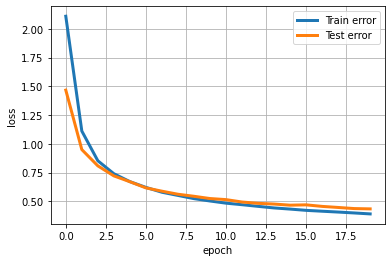

In [91]:
import matplotlib.pyplot as plt

plt.plot(range(20),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(20),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

In [92]:
from torchvision.transforms.functional import accimage
predicted_output = net(images)
print(torch.max(predicted_output, 1))
fit = Loss(predicted_output, labels)
print(labels)
print(fit)

torch.return_types.max(
values=tensor([ 7.2505,  2.3631, 13.8050, 13.7136,  9.4267,  8.6860, 11.6090,  4.9544,
         9.9191, 12.1755, 15.5478, 12.5551, 11.1040,  9.3838, 11.4389,  6.8763],
       device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([3, 0, 7, 5, 8, 4, 5, 6, 8, 9, 1, 9, 1, 8, 1, 5], device='cuda:0'))
tensor([3, 2, 7, 5, 8, 4, 5, 6, 8, 9, 1, 9, 1, 8, 1, 5], device='cuda:0')
tensor(0.1938, device='cuda:0', grad_fn=<NllLossBackward0>)


In [93]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
net.eval() # prep model for evaluation
for data, target in testDataLoader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = net(data.cuda())
    # calculate the loss
    loss = Loss(output, target.cuda())
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred).cuda()))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
# calculate and print avg test loss
test_loss = test_loss/len(testDataLoader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.388194

Test Accuracy of     0: 81% (815/1000)
Test Accuracy of     1: 95% (953/1000)
Test Accuracy of     2: 75% (755/1000)
Test Accuracy of     3: 88% (887/1000)
Test Accuracy of     4: 76% (764/1000)
Test Accuracy of     5: 94% (940/1000)
Test Accuracy of     6: 63% (635/1000)
Test Accuracy of     7: 94% (940/1000)
Test Accuracy of     8: 95% (959/1000)
Test Accuracy of     9: 94% (944/1000)

Test Accuracy (Overall): 85% (8592/10000)


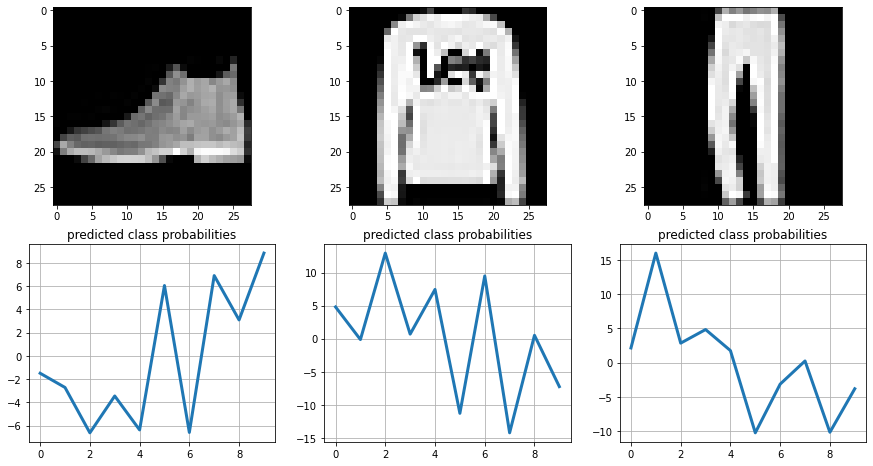

In [94]:
images, labels = iter(testDataLoader).next()

plt.figure(figsize=(15,8))
# Plotting 3 image samples from the test dataset
for index in np.arange(0,3):
  plt.subplot(2,3,index+1)
  plt.imshow(images[index].cpu().squeeze().numpy(),cmap=plt.cm.gray)
  
# Visualize the predicted class probabilities for each sample
for index in np.arange(0,3):
  plt.subplot(2,3,index+4)
  sample_predicted_output = net(images[index].cuda())
  sample_predicted_output=sample_predicted_output.cpu().detach().numpy()
  plt.plot(range(10),sample_predicted_output[0],'-',linewidth=3)
  plt.title('predicted class probabilities')
  plt.grid(True)

From the sample graph above we can see that the first one is a shoe, and the model calculates the probabilities for each classes, and class 9 has the highest probability. So the model labels the image as class 9.

For the second image, we can that it is a T-shirt, and the model has the highest probability in class 2, so the second image is labeled as class 2.

The third image shows a pair of pants, and the model has the highest probability in class 1, so the third image is labeled as class 1.
